# Exercises Week 9: Temperature regulated gene expression

**Course**: [Topics in life sciences engineering](https://moodle.epfl.ch/enrol/index.php?id=17061) (BIO-411)

**Professors**:  _Gönczy Pierre_, _Naef Felix_, _McCabe Brian Donal_

SSV, MA, 2023-2024


This week's exercises are inspired by the work of [Gotic et al., 2015](http://genesdev.cshlp.org/content/30/17/2005), in which RNA levels, including pre-mRNA and mRNA (total RNA-seq), were measured in mouse NIH-3T3 fibroblasts after cells were switched from a warm to a colder temperature (38C° to 33C°), and vice versa (33C° to 38C°).
The experiments were conducted over multiple time points in an "*approach to steady-state*" design. The cold-inducible *Cirbp* gene was used as an example to examine the kinetics and mechanisms of post-transcritional control of gene expression. 

## Setup the Jupyter environment 
In order to run this notebook, we advise you to use the EPFL's JupyterLab centralized platform [noto.epfl.ch](http://noto.epfl.ch). Some of the required libraries are not available on the platform but you can install them copy-pasting the following commands in the **Jupyter Terminal** (open a new tab with the '+' icon and select "Terminal"):

````
my_venvs_create Week9_env
my_venvs_activate Week9_env
pip install gseapy
pip install adjustText
my_kernels_create Week9_env “Week9”
my_venvs_deactivate
````
Refresh your browser's page and select $\textbf{\color{red}the "Week9" kernel}$ using the top right toggle button. Import the libraries running the code cell below.

In [1]:
## Import libraries
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from scipy.integrate import odeint

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

import gseapy as gp
from ipywidgets import interact, fixed
from adjustText import adjust_text


## Exercise 0: "Temperature regulates splicing efficiency of the cold-inducible RNA-binding protein gene *Cirbp*"
Carefully read the paper and answer the following questions:

1. What is the physiological situation described in the introduction?  

2. What experiments did the authors conduct to confirm the post-transcriptional regulation of *Cirbp* mRNA accumulation?  

3. How did the authors distinguish between the regulation at the degradation and splicing level for *Cirbp*?  

4. Describe the methods used by the authors to obtain genome-wide transcription and mRNA accumulation levels, and how they characterized genes induced by cold and heat.  

Hint: Be sure to reference the figure panels that support your answers.

## Answer 0:
**1.**  Core body temperature (CBT). In mammals, CBT shows diurnal oscillation under the control of the circadian timekeeping system.  

**2.**  The authors used multiple experiments:
  
* RNase protection assays (RPAs) at low and high temperatures (Figure 1).  

* Chromatin immunoprecipitation (ChIP) against PolII and quantification on the *Cirbp* promoter at low and high temperatures (Figure 2A).  
 
* A CIRBP-luciferase fusion gene driven by a CMV promoter (Figure 2C).  

**3.** They estimated the kinetic parameters of *Cirbp* at both temperatures using an approach to steady-state combining qPCR, RNA-seq and mathematical modelling (Figures 3 and 4).  

**4.** RNA-seq combined with separate quantification of intronic (*i.e.* a proxy for transcription) and exonic read counts (*i.e.* a proxy for mRNA accumulation).  

## Exercise 1: Simulation of a simplified production-decay ODE model of transcription

We first consider a system in which nuclear pre-mRNA is transcribed and subsequently spliced to produce mRNA.  
Both molecular species are subject to distinct degradation processes, which can be modeled with a two-dimensional system of ordinary differential equations (ODEs):

\begin{aligned}
&\frac{dP}{dt} = s - (k_p + \rho)P \\
&\frac{dM}{dt} = \rho P - k_m M \\
\end{aligned}

where $P$ and $M$ represent the concentrations of pre-mRNA and mRNA, respectively.

Here, $s$ the transcription rate, is assumed to be a constant, but could also be a time-dependent function $s(t)$ (this will be explored further in the exercise session for Week 11).  
The parameters $k_m$ and $k_p$ are the degration rates of $M$ and $P$, respectively, while $\rho$ is the splicing rate of pre-mRNA $P$ into mRNA $M$; these rates are also constants.  
When all parameters are constant, the system will reach steady-state levels after a transient period, meaning that the derivatives $\frac{dP}{dt}$ and $\frac{dM}{dt}$ will equal to zero.

### Question 1
1. Derive the steady-state concentrations and interpret what happens to $M$ when $\rho\gg k_p$.  

2. Compute the steady-state ratio mRNA/pre-mRNA.   
    a. Comment on the result, in particular discuss which parameters are important and which are not.  
    b. Discuss how this ratio might be used to compare mRNA half-lives across different conditions.

3. Find realistic values for $\rho$, $s$, and $k_m$ in typical mammalian cells (e.g. NIH-3T3 fibroblasts) from the litterature.  

4. Using those values, estimate the ratio of mRNA to pre-mRNA molecules in typical mammalian cells.

### Answer 1

**1.** At steady-sate, $\frac{dP}{dt}=\frac{dM}{dt}$=0, therefore:  
\begin{aligned}
&P = \frac{s}{(k_p + \rho)} \\
&M = \frac{s}{k_m}\frac{\rho}{(k_p + \rho)} \\
\end{aligned}  
When $\rho\gg k_p$, M depends only on the synthesis and degradation rate $s$ and $k_m$, respectively, as the term $\frac{\rho}{(k_p + \rho)}$ approximates to 1.
 
**2.**  

  - **a.** The steady-state ratio $\frac{M}{P}=\frac{\rho}{k_m}$ depends only on the splicing rate $\rho$ and the degradation rate of the mRNA, $k_m$.
  - **b.** Measuring the ratio mRNA/pre-mRNA (*e.g.* using RNA-seq exon/intron count) allows for comparison of mRNA half-life or splicing rate across different conditions, depending on the hypothesis.  

**3.** Realistic values from the literature for typical mammalian cells like NIH-3T3 fibroblasts are  $\rho = 2 h^{-1}$ (30 min), $s = 1 [\text{P}]h^{-1}$, and $k_m = 0.1 h^{-1}$ (10 hours).

**4.** The ratio $\frac{M}{P}=\frac{\rho}{k_m}$ = $\frac{2}{0.1}$ = 20, indicating that there are around 20 times more mRNA molecules than pre-mRNA molecules in typical mammalian cells at steady-state.








### Question 2 
Simulate the production-decay ODE with a constant transcription rate $s$ using the provided code:
1. Use the interactive widget (described below) to vary parameters such as splicing rate ($\rho$), degradation rates ($k_p$ and $k_m$) and transcription rate ($s$).\
Experiment with different initial conditions for the pre-mRNA and mRNA concentrations as well.

2. Adapt the code by adding a few lines to plot the steady-state concentrations of pre-mRNA and mRNA, as derived in Question 1.1. 

3. Optional: Extend the model by incorporating a third differential equation that represents the protein level. Update the simulation and the corresponding plots to include protein dynamics. 

Remember to clearly label all axes and legends on your plots for easy interpretation.

### Answer 2  

1. *See code below*  

2. *See code below*  


3. We can add one more differential equation to describe the protein dynamic:  

\begin{aligned}
&\frac{dG}{dt}= \tau M - k_gG
\end{aligned}

where $G$ is the concentration of the protein, $\tau$ the protein synthesis rate and $k_g$ the degradation rate of the protein. See code below.



#### Definition of important functions


In [2]:
def production_decay_ode(y, time, s, kp, km, rho, tau, kg):

    """
    Defines the ODEs for the production and decay of pre-mRNA and mRNA.
    P: pre-mRNA concentration
    M: mRNA concentration
    s: transcription rate (constant)
    kp: pre-mRNA degradation rate
    km: mRNA degradation rate
    rho: splicing rate
    tau: protein synthesis rate
    kg: protein degradation rate
    """
    
    P, M, G = y
    dPdt = s - (kp + rho) * P
    dMdt = rho * P - km * M
    dGdt = tau * M - kg * G
    return [dPdt, dMdt, dGdt] 


def simulation(ode_function, parameters, initial_conditions = None, time = None):

    """
    Simulate the ODEs for the production and decay of pre-mRNA and mRNA.
    parameters: parameters for the ODEs
    initial_conditions: initial conditions for the ODEs
    time: time intervals for the simulation
    """

    s = parameters['s']
    kp = parameters['kp']
    km = parameters['km']
    rho = parameters['rho']
    tau = parameters['tau']
    kg = parameters['kg']

    # Placeholder for adding steady-state solutions

    P_ss = s / (kp + rho) #Add your steady-state solution for P here 
    M_ss = (s / km) * (rho / (kp + rho)) #Add you steady-state solution for M here
    
    results = odeint(ode_function, initial_conditions, time, args=(s, kp, km, rho, tau, kg))

    plt.figure(figsize=(10, 6))
    plt.ylim([0,150])

    # Uncomment the lines below after adding your steady-state solutions
    plt.axhline(y=P_ss, color='blue', linestyle='--', label='P_ss')  
    plt.axhline(y=M_ss, color='orange', linestyle='--', label='M_ss')

    plt.title('Simulation of pre-mRNA and mRNA Production-Decay Dynamics')
    plt.plot(time, results[:, 0], label = 'P(t)', linewidth=2)
    plt.plot(time, results[:, 1], label = 'M(t)', linewidth=2)
    plt.legend()

    plt.twinx()
    plt.plot(time, results[:, 2], label = 'G(t)', linewidth=2, color='green') 
    plt.ylim([0,4000])

    plt.xlabel("Time [min]")
    plt.ylabel("Concentration")
    plt.legend(loc='upper left')
    plt.show()
    
def animate(initial_conditions, time, s=5, kp= 0.05, km=0.05, rho=0.4, tau=0.04, kg=0.016):
    """
    Runs the simulation with an interactive widgets for parameter exploration.
    """
      
    parameters = {'s':s,'kp':kp, 'km':km, 'rho':rho, 'tau':tau, 'kg':kg}
    simulation(production_decay_ode, parameters, initial_conditions, time)


#### Run the simulation

In [3]:

# Define initial conditions and time intervals for the simulation
initial_conditions = [0, 0, 0] #[P, M, G]
time = np.linspace(0, 500, 10001)

interact(animate, 
         initial_conditions=fixed(initial_conditions), 
         time=fixed(time), 
         s = (1,10,0.01), #  Transcription rate units: concentration [P] per min    
         kp = (1/120,1/10,1/1000), # Pre-mRNA degradation rate units: 1/min (range: 10 min to 120 min)
         km = (1/600,1/10,1/1000),  # mRNA degradation rate units: 1/min (range: 10 min to 600 min)
         rho = (1/30,1,0.05), #splicing rate units: 1/min (range: 1 min to 30 min)
         tau = (1/30,1,1/100), #unit of tau is number of proteins per min per molecules of M [1/30 min^-1, 1 min^-1]
         kg = (1/(24 * 60), 1/60,1/1000)); #kg^-1 in [60min, 24*60min]

interactive(children=(FloatSlider(value=5.0, description='s', max=10.0, min=1.0, step=0.01), FloatSlider(value…

## Exercise 2: RNA-seq analysis and modelling of gene expression response to temperature up- and down-shifts

In [Gotic et al., 2015](http://genesdev.cshlp.org/content/30/17/2005), cells were harvested at various time points (0, 1, 3, 6, and 9 hours) after a temperature switch from 33°C to 38°C and vice versa, with duplicates subjected to total RNA-seq analysis. The resulting data were processed to assign reads to pre-mRNA and mRNA species and to obtain their respective levels. Here, we will analyze those data to study and model gene expression responses to temperature shifts.

The functions provided below (run the cell) will assist you in the analysis.

#### Implementation of useful functions

In [4]:
def subselect(data, feature, replicate, time, condition):

    """
    Subselects samples from the full dataset based on the specified features, conditions, 
    replicates, and time points.

    Parameters:
    data: The full gene expression dataset.
    feature: The features to filter by (e.g., ['intron', 'exon']).
    replicate: The replicates to include.
    time: The time points to include.
    condition: The temperature shift conditions to include (e.g, ['33to38', '38to33']).

    Returns:
    pd.DataFrame: The filtered dataset.
    """
    
    # Create boolean masks for each filtering criterion

    feature_mask  = data.columns.get_level_values('feature').isin(feature)
    condition_mask  = data.columns.get_level_values('condition').isin(condition)
    replicate_mask  = data.columns.get_level_values('replicate').isin(replicate)
    time_mask = data.columns.get_level_values('time').isin(time)

    # Use the masks to filter the data

    filtered_data = data.iloc[:, feature_mask & condition_mask & replicate_mask & time_mask]
    
    return filtered_data

def run_PCA(data, n_components=5, color_by='replicate', symbol_by='time', scale_data=True, log_transform=True):
    
    """
    Runs PCA on the provided data and generates a scatter plot of pairs of principal components.
    It also returns a DataFrame containing the PCA loadings.

    Parameters:
    data: The gene expression data to analyze.
    n_components: The number of principal components to calculate.
    color_by: The metadata category to color the data points by.
    symbol_by: The metadata category to symbolize the data points by.
    scale_data: Whether to scale the data before PCA.
    log_transform: Whether to apply log transformation to the data.

    Returns:
    pd.DataFrame: A DataFrame containing the PCA loadings.
    """

    data_tmp = data.copy()
    
    # Scale and/or log-transform the data if specified
    if scale_data:
        data = scale(data)
    else:
        data = data
        
    if log_transform:
        data = np.log2(data + 1)
        
    # Fit the PCA model
    pca = PCA(n_components=n_components)
    pca.fit(data.T)

    # Transform the data
    pca_transformed = pca.transform(data.T)

    # Create a DataFrame for the PCA results
    labels = [f'PC{i+1}' for i in range(n_components)]
    pca_df = pd.DataFrame(pca_transformed, columns=labels)
    pca_df[color_by] = data_tmp.columns.get_level_values(color_by)
    pca_df[symbol_by] = data_tmp.columns.get_level_values(symbol_by)

    # Plotting each pair of consecutive principal components
    fig, axes = plt.subplots(1, n_components -1, figsize=(30, 5))
    for i in range(n_components-1):
        sns.scatterplot(ax=axes[i], data=pca_df, x=f'PC{i+1}', y=f'PC{i+2}', 
        hue=color_by, style=symbol_by, s=200, palette='Set1')

        axes[i].set_xlabel(f'PC{i+1} ({pca.explained_variance_ratio_[i]*100:.2f}%)')
        axes[i].set_ylabel(f'PC{i+2} ({pca.explained_variance_ratio_[i+1]*100:.2f}%)')
        # remove legend if it's not the first plot
        if i != 0:
            axes[i].get_legend().remove()
    
    fig.suptitle(f'PCA of Gene Expression Data (color={color_by}, symbol={symbol_by})', fontsize=16)

    # Return the PCA loadings
    df_pca = pd.DataFrame(pca.components_, columns=data_tmp.index, index=labels)

    return df_pca


## Plot Gene profile across all conditions
def plot_gene(data, gene , xx_33_38=None, xx_38_33=None, t_2=None):

    """
    Plots the gene expression profile across different conditions and time points.
    
    Parameters:
    data: The gene expression data.
    gene: The gene to plot.
    xx_33_38: The simulated solution for the 33to38 condition.
    xx_38_33: The simulated solution for the 38to33 condition.

    Returns:
    None
    """

    #subselect
    time= ['0', '1' ,'3' ,'6', '9']
    replicate = ['2', '13', '11', '5']
    dat_1= subselect(data, ['intron'], replicate, time, ['33to38'])
    dat_2= subselect(data, ['exon'], replicate, time, ['33to38'])
    dat_3= subselect(data, ['intron'], replicate, time, ['38to33'])
    dat_4= subselect(data, ['exon'], replicate, time, ['38to33'])

    #plot
    t=np.array([0, 0, 1, 1, 3, 3, 6, 6, 9 , 9])
    fig, axs = plt.subplots(2, 2, figsize=(8,8), sharex=True)
    
    axs[0, 0].plot(t, dat_1[dat_1.index.str.endswith(gene)].values.T, 'o', color = 'lightblue', label='intron 33to38')
    axs[0, 0].set_title("intron 33to38")
    
    axs[1, 0].plot(t, dat_2[dat_2.index.str.endswith(gene)].values.T, 'o', color = 'lightblue', label='exon 33to38')
    axs[1, 0].set_title("exons 33to38")
    
    axs[0, 1].plot(t, dat_3[dat_3.index.str.endswith(gene)].values.T, 'o', color = 'lightblue', label='intron 38to33')
    axs[0, 1].set_title("intron 38to33")

    axs[1, 1].plot(t, dat_4[dat_4.index.str.endswith(gene)].values.T, 'o', color = 'lightblue', label='exon 38to33')
    axs[1, 1].set_title("exon 38to33")

    if xx_33_38 is not None:
        axs[0,0].plot(t_2, xx_33_38[:,0],label = 'P(t)')
        axs[1,0].plot(t_2, xx_33_38[:,1])
        axs[0,1].plot(t_2, xx_38_33[:,0])
        axs[1,1].plot(t_2, xx_38_33[:,1])
    
        
    for ax in axs.flat:
        ax.set(xlabel='Time [h]', ylabel='RPKM')

    fig.suptitle(f'Gene Expression Profile for {gene}', fontsize=16)
    plt.show()

def plot_DE(dat_all, condition_x1, condition_x2, condition_y1, condition_y2, time_x1, time_x2, time_y1, time_y2, feature_x1, feature_x2, feature_y1, feature_y2, FC=2, xlab="", ylab="", FC_type="delta"):
    
    """
    Plots differentially expressed genes based on log fold changes between specified conditions, times, and features.

    Parameters:
    dat_all: The complete dataset with gene expression values.
    condition_x1, condition_x2, condition_y1, condition_y2: Lists of conditions to compare.
    time_x1, time_x2, time_y1, time_y2: Lists of time points to compare.
    feature_x1, feature_x2, feature_y1, feature_y2: Lists of features to compare.
    FC: Absolute fold change threshold for considering a gene differentially expressed in at least one of the two axes.
    xlab: Label for the x-axis representing the log fold change between condition_x2 and condition_x1.
    ylab: Label for the y-axis representing the log fold change between condition_y2 and condition_y1.

    Returns:
    Array: Boolean array indicating differentially expressed genes that meet the fold change threshold.
    """
     
    replicate = ['2', '13', '11', '5']

    dat_x1=subselect(dat_all, feature_x1, replicate, time_x1, condition_x1).mean(axis=1)
    dat_x2=subselect(dat_all, feature_x2, replicate, time_x2, condition_x2).mean(axis=1)

    dat_y1=subselect(dat_all, feature_y1, replicate, time_y1, condition_y1).mean(axis=1)
    dat_y2=subselect(dat_all, feature_y2, replicate, time_y2, condition_y2).mean(axis=1)

    x=np.log2(1 + dat_x2)- np.log2(1 + dat_x1)
    y=np.log2(1 + dat_y2) - np.log2(1 + dat_y1)

    if FC_type == "delta":
        pos =((x > FC) & (y > FC)) | ((x < -FC) & (y < -FC))

    if FC_type == "delta_delta":
        pos = abs(x-y) > FC

    x_2 = x[pos]
    y_2 = y[pos]
    fig, ax = plt.subplots(figsize=(10,10))

    ax.plot(x,y, 'o', color = 'lightblue', markersize=2)
    ax.axhline(y=0, color='b')
    ax.axvline(x=0, color='b')
    ax.set_xlim(-8,8)
    ax.set_ylim(-8,8)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    texts = [ax.text(x_2[k], y_2[k], v.split("|")[1]) for k, v in enumerate(dat_all.index[pos])]
    adjust_text(texts)
    
    return(pos)    


###  Question 1

**PCA**

*"Principal Component Analysis (PCA) is a dimensionality reduction technique that simplifies complex datasets by transforming them into a set of orthogonal axes, or principal components, that summarize the underlying patterns of variation. It works by calculating the eigenvectors and eigenvalues from the covariance matrix of the data, which then define the new axes. The first principal component captures the largest amount of variance in the data, with each subsequent component—perpendicular to the last—capturing progressively less variance. This orthogonal nature of PCA ensures that each component adds distinct information. When applied to gene expression data, PCA reduces the numerous gene variables to a few composite indicators without losing critical information. After transformation, each principal component represents a combination of genes. The loadings of these components then tell us about the contribution of each gene to the component. Genes with high absolute loadings have a greater role in defining the structure revealed by that component, allowing us to identify which genes are most responsible for differentiating the samples on the basis of the observed variance."*

**GO enrichment analysis (GEA)**

*"Gene Ontology (GO) analysis is a common bioinformatics technique used to gain insight into the biological significance behind large lists of genes. When we perform experiments that result in the identification of many genes, such as with RNA-seq, we often want to understand the underlying biology of these genes. However, looking at each gene individually can be overwhelming due to the sheer number. This is where GO analysis comes in handy. GO analysis categorizes genes into groups known as "GO terms" describing different aspects of molecular biology or pathways. Using GO analysis, we can identify which biological processes are enriched in our gene list—meaning that these categories contain more genes from our list than we would expect by chance. This can suggest that the genes are collectively involved in certain biological functions or pathways, which may be crucial to the condition or treatment we're studying."*
  
Using the provided code below (PCA and enrichR cells), explore the RNA-Seq data:

1. Perform principal component analysis (PCA) selecting different temperature conditions, time points, replicates and features (i.e. intron or exon). For each scenario described below, explore the principal components (PCs) and comment:
  
    a. With all samples included, determine the primary sources of variance. Is there an outlier? Do replicates cluster as expected?  
    b. Focus on exonic counts and identify which principal component correlates with time.  
    c. Limit the selection to exonic counts under a single condition (38to33 or 33to38) and evaluate the transcriptome response over time. Are there notable differences between the two conditions? 

2. Extract gene PCA loadings (positive or/and negative) from relevant sample groups and principal components. 
Use enrichR for Gene Enrichment Analysis (GEA) to uncover biological functions or regulatory mechanisms associated with temperature-responsive gene expression (heat- or cold-induced gene responses). 
Choose diverse databases within enrichR, such as 'GO_Biological_Process_2021', 'GO_Molecular_Function_2021', 'WikiPathways_2019_Mouse'.

    a. Identify gene functions that are temperature-regulated.  
    b. Compare cold-induced versus heat-induced gene functions. What differences do you find?    
    c. Advanced (Optional): Identify the main sources of variance between replicates and discuss their implications.

*Modify only the code marked as 'PCA cell' and 'enrichR' below*.

#### Load the RNA-seq data (normalized counts) and format it as a panda data.frame


In [5]:

#Load 33to38 data
dat_33_38 = pd.read_csv("./GoticData/GSE85553_33-38_exon_intron_RPKM.txt",sep='\t')
dat_33_38=dat_33_38.add_prefix("33to38.")

#Load 33to38 data
dat_38_33 = pd.read_csv("./GoticData/GSE85553_38-33_exon_intron_RPKM.txt",sep='\t')
dat_38_33=dat_38_33.add_prefix("38to33.")

#concatenate
dat_all = pd.concat([dat_33_38, dat_38_33.iloc[:, :20]],axis=1)
dat_all.columns=dat_all.columns.str.replace('\.t','.', regex=True)
dat_all.replace([np.inf, -np.inf], 0, inplace=True)

#create column names
dat_all.columns=dat_all.columns.str.split('.', expand = True)
dat_all.columns.names = ['condition','time','replicate','feature']

# have a look at the data
dat_all.head()

condition                  33to38                                          \
time                            0                             1             
replicate                      13              2             13             
feature                      exon    intron exon    intron exon    intron   
ENSMUSG00000090025|Gm16088    0.0  0.000000  0.0  0.000000  0.0  0.000000   
ENSMUSG00000064842|U6         0.0  0.000000  0.0  0.000000  0.0  0.000000   
ENSMUSG00000051951|Xkr4       0.0  1.972758  0.0  7.955391  0.0  3.763305   
ENSMUSG00000089699|Gm1992     0.0  0.000000  0.0  0.980092  0.0  0.000000   
ENSMUSG00000088390|U7         0.0  0.000000  0.0  0.000000  0.0  0.000000   

condition                                                ... 38to33            \
time                                         3           ...      3             
replicate                     2             13           ...      5             
feature                    exon    intron exon   intron  ...   exon    intron   
ENSMUSG00000090025|Gm16088  0.0  0.000000  0.0  0.00000  ...    0.0  0.000000   
ENSMUSG00000064842|U6       0.0  0.000000  0.0  0.00000  ...    0.0  0.000000   
ENSMUSG00000051951|Xkr4     0.0  1.941199  0.0  3.90031  ...    0.0  4.871782   
ENSMUSG00000089699|Gm1992   0.0  0.000000  0.0  0.00000  ...    0.0  0.000000   
ENSMUSG00000088390|U7       0.0  0.000000  0.0  0.00000  ...    0.0  0.000000   

condition                                                                     \
time                          6                             9                  
replicate                    11              5             11              5   
feature                    exon    intron exon    intron exon    intron exon   
ENSMUSG00000090025|Gm16088  0.0  0.000000  0.0  0.000000  0.0  0.000000  0.0   
ENSMUSG00000064842|U6       0.0  0.000000  0.0  0.000000  0.0  0.000000  0.0   
ENSMUSG00000051951|Xkr4     0.0  3.863257  0.0  4.953918  0.0  2.945545  0.0   
ENSMUSG00000089699|Gm1992   0.0  0.000000  0.0  1.000000  0.0  0.000000  0.0   
ENSMUSG00000088390|U7       0.0  0.000000  0.0  0.000000  0.0  0.000000  0.0   

condition                             
time                                  
replicate                             
feature                       intron  
ENSMUSG00000090025|Gm16088  0.000000  
ENSMUSG00000064842|U6       0.000000  
ENSMUSG00000051951|Xkr4     1.963427  
ENSMUSG00000089699|Gm1992   0.568750  
ENSMUSG00000088390|U7       0.000000  

[5 rows x 40 columns]

#### Keep expressed genes (i.e. genes with mean expression > 1 and > 10 RPKM in intron and exon quantification, respectively)


In [6]:
time= ['0', '1' ,'3' ,'6', '9']
replicate = ['2', '13', '11', '5']
conditions = ['33to38','38to33']

dat_intron= subselect(dat_all, ['intron'], replicate, time, conditions)
dat_exon= subselect(dat_all, ['exon'], replicate, time, conditions)
dat_all = dat_all.loc[(dat_intron.mean(axis=1) > 1 ) & (dat_exon.mean(axis=1) > 10), :]

### PCA
#### Perform PCA selecting different temperature conditions, timepoints, replicate and features (intron vs. exon). Change those parameters to select different samples for the PCA.

### Answer 1

**1a.** The feature type (intron or exon) accounts for most of the variance in the data (PC1). Additionally, samples within each replicate cluster closely, yet the different replicates are dispersed along PC2 (refer to the PC2 vs PC3 plot). There appears to be one outlier identified as sample condition=33to38, time=9h, replicate=11, feature=intron. See code below.

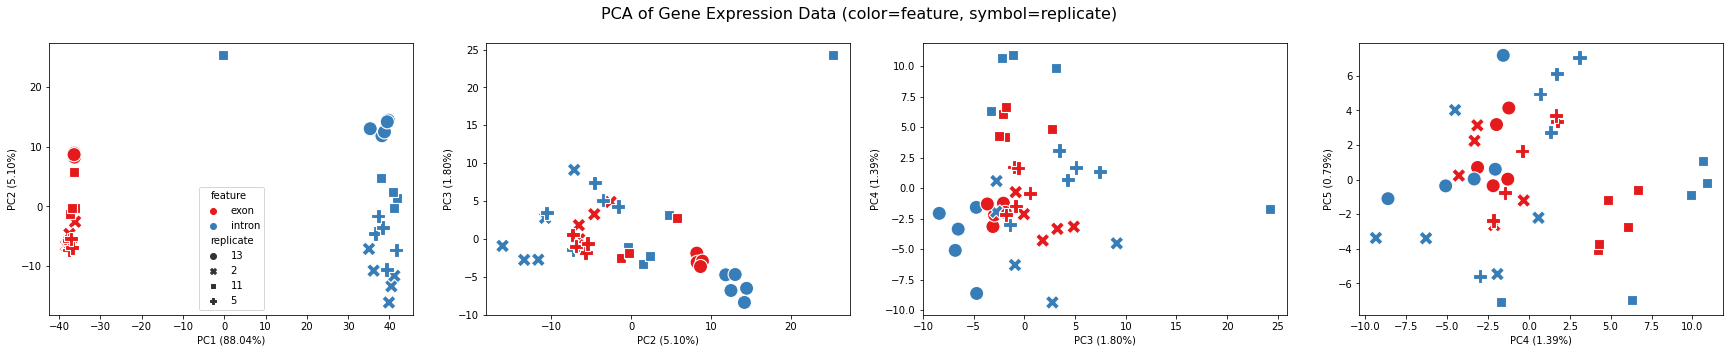

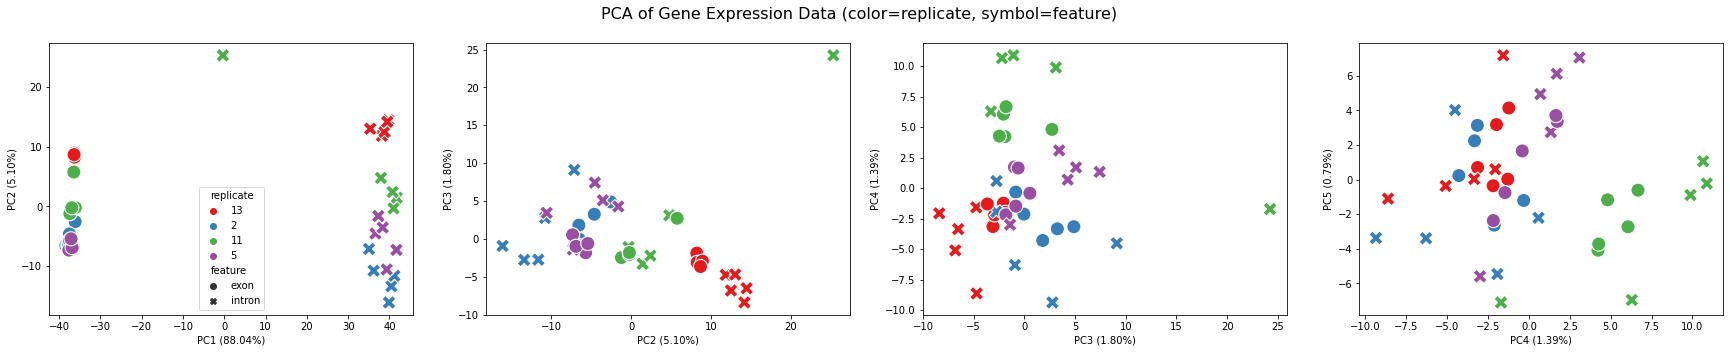

In [7]:

#Choose the features, conditions, replicates, and time points to include in the analysis for the different questions.
condition = ['38to33','33to38'] 
time= ['0', '1' ,'3' ,'6', '9']
replicate = ['2', '13', '11', '5'] # replicates 13 and 2 are from the 33to38 experiment, 5 and 11 from the 38to33.
feature = ['intron', 'exon']

#Subselect the samples 
dat_sub = subselect(dat_all, feature, replicate, time, condition)

#Perform the PCA, plot, and return the PCA loadings. Adjust the parameters color_by and symbol_by to answer to the different question.
PC_loadings_all = run_PCA(dat_sub, n_components=5, color_by='feature', symbol_by='replicate', scale_data=True, log_transform=True)
run_PCA(dat_sub, n_components=5, color_by='replicate', symbol_by='feature', scale_data=True, log_transform=True);


**1b.** In the PC1 vs. PC2 plot, there is clear clustering by replicate and condition, except for two samples from replicate "2" (condition 33to38) that cluster with samples from replicate "5" (condition 38to33). In the PC2 vs. PC3 plot, time correlates with PC3. The samples are arranged according to time; for the 33to38 condition, time increases along PC3, and for the 38to33 condition, it decreases. During the upshift experiment, mRNA levels reach a steady state more rapidly, as indicated by the overlapping of samples from t=6 (purple) and t=9 (orange), compared to the downshift experiment.

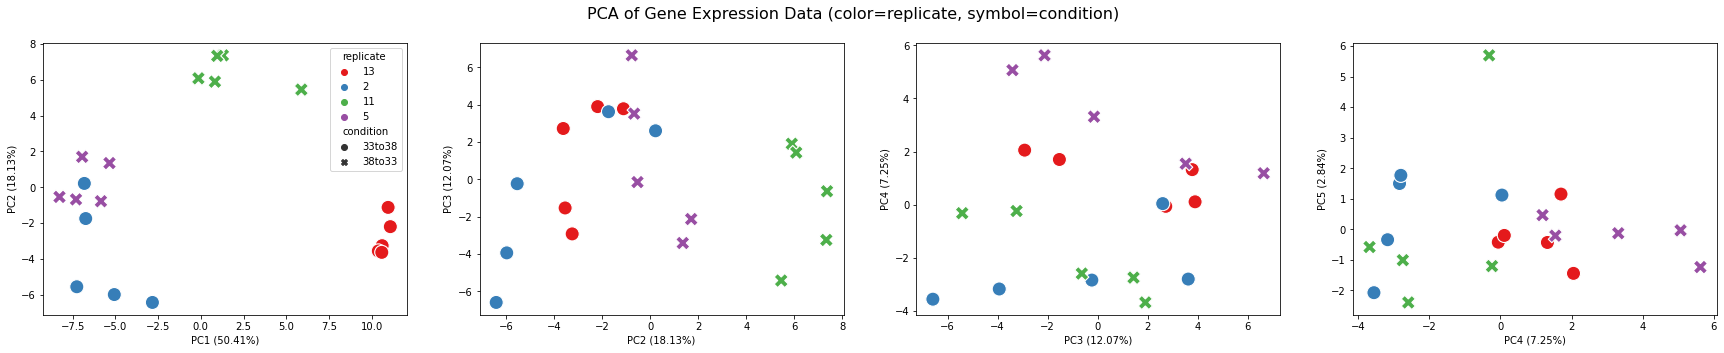

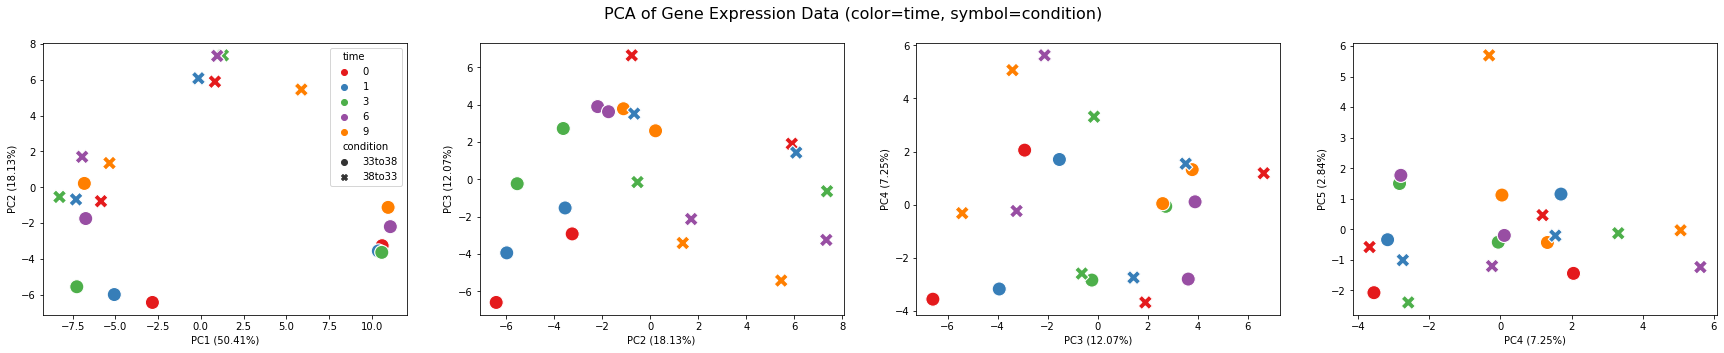

In [8]:

#Choose the features, conditions, replicates, and time points to include in the analysis for the different questions.
condition = ['38to33','33to38'] 
time= ['0', '1' ,'3' ,'6', '9']
replicate = ['2', '13', '11', '5'] # replicates 13 and 2 are from the 33to38 experiment, 5 and 11 from the 38to33.
feature = [ 'exon']

#Subselect the samples 
dat_sub = subselect(dat_all, feature, replicate, time, condition)

#Perform the PCA, plot, and return the PCA loadings. Adjust the parameters color_by and symbol_by to answer to the different question.
PC_loadings_exon = run_PCA(dat_sub, n_components=5, color_by='replicate', symbol_by='condition', scale_data=True, log_transform=True)
run_PCA(dat_sub, n_components=5, color_by='time', symbol_by='condition', scale_data=True, log_transform=True);


**c.** The samples display a chronological ordering along PC2. As mentioned in *b*, during the upshift, mRNA levels achieve steady-state more quickly, which is shown by the overlap of samples from t=6 and t=9, in contrast to the downshift where the transition is more gradual.

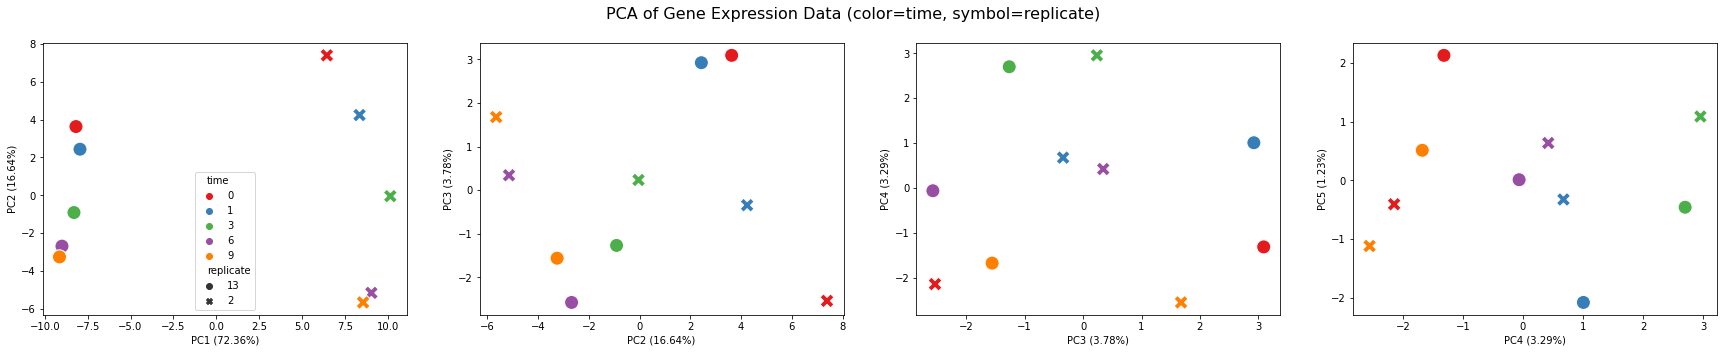

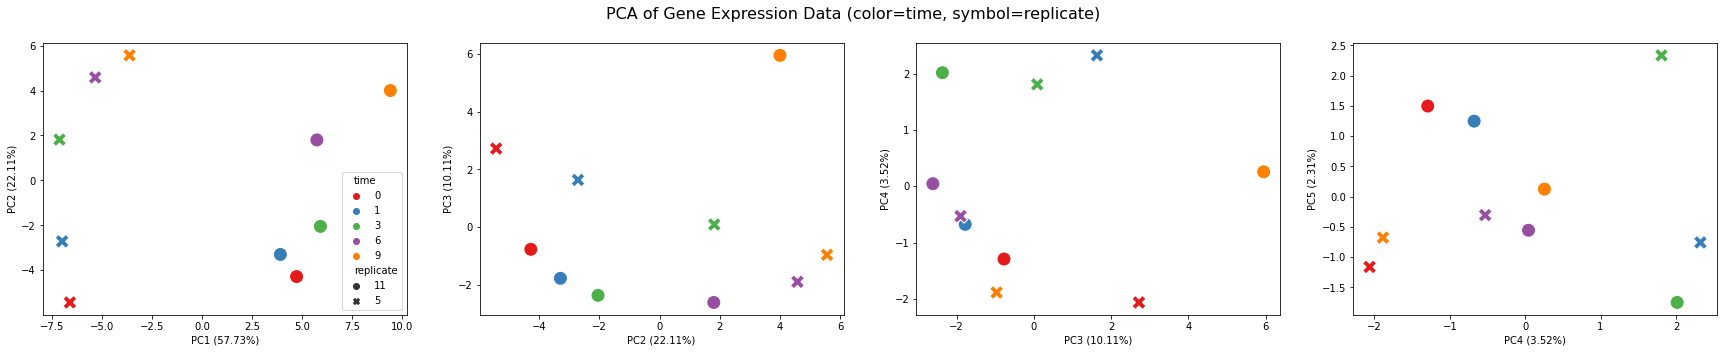

In [9]:
#Choose the features, conditions, replicates, and time points to include in the analysis for the different questions.
time= ['0', '1' ,'3' ,'6', '9']
replicate = ['2', '13', '11', '5'] # replicates 13 and 2 are from the 33to38 experiment, 5 and 11 from the 38to33.
feature = [ 'exon']

#Subselect the samples 

condition = ['33to38']
dat_sub_33_38 = subselect(dat_all, feature, replicate, time, condition)

condition = ['38to33']
dat_sub_38_33 = subselect(dat_all, feature, replicate, time, condition)


#Perform the PCA, plot, and return the PCA loadings. Adjust the parameters color_by and symbol_by to answer to the different question.
PC_loadings_33_38 = run_PCA(dat_sub_33_38, n_components=5, color_by='time', symbol_by='replicate', scale_data=True, log_transform=True) #upshift
PC_loadings_38_33 = run_PCA(dat_sub_38_33, n_components=5, color_by='time', symbol_by='replicate', scale_data=True, log_transform=True) #downshift


### enrichR
#### Perform GO term enrichment analysis

In [10]:
enrichr_mouse_GO = gp.get_library_name(organism='Mouse') # you can explore the enrichr libraries using this function

**2a.** Genes with large loadings (absolute value) on PC3, as identified in 1b, are associated with different biological functions. We observed enrichment in genes related to the cell cycle, unfolded protein response (heat-shock), and mRNA processing (including Cirbp). The analysis of transcription factor enrichment indicates over-representation of key cell-cycle regulators (such as TOP2A, E2F1). Refer to the code below for a selection of examples; this list is not exhaustive.

In [11]:
nb_genes = 100 # select the number of genes to use for the enrichment analysis
pca_selected_loadings = PC_loadings_exon # select the pca loadings to use for the enrichment analysis
PC = 'PC3' # select the principal component to use for the enrichment analysis

# select the top and bottom genes for the selected principal component
bottom = pca_selected_loadings.sort_values(by=PC,axis=1).columns[:nb_genes]
top = pca_selected_loadings.sort_values(by=PC,axis=1).columns[-nb_genes:]

# create a list of genes to use for the enrichment analysis
top_bot = top.union(bottom) # you can use only top or bottom here as well
gene_list = top_bot.str.split("|").str[1].to_series().str.upper()
gene_list = gene_list.squeeze().str.strip().to_list()

# run the enrichment analysis
enr = gp.enrichr(gene_list=gene_list,
                 gene_sets='GO_Biological_Process_2021',
                 organism='mouse', 
                 outdir=None)
display(enr.results.head(10))
enr = gp.enrichr(gene_list=gene_list,
                 gene_sets='WikiPathways_2019_Mouse',
                 organism='mouse', 
                 outdir=None)
display(enr.results.head(10))
enr = gp.enrichr(gene_list=gene_list,
                 gene_sets='ChEA_2022',
                 organism='mouse', 
                 outdir=None)
display(enr.results.head(10))

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,mitotic spindle organization (GO:0007052),19/157,1.759848e-15,3.114931e-12,0,0,14.956282,508.117961,DCTN2;PLK1;BUB1B;KIF23;KIF11;DYNLL1;RANGAP1;CK...
1,GO_Biological_Process_2021,microtubule cytoskeleton organization involved...,17/128,1.171093e-14,1.036417e-11,0,0,16.477773,528.578179,DCTN2;PLK1;BUB1B;KIF11;DYNLL1;RANGAP1;CKAP5;CE...
2,GO_Biological_Process_2021,regulation of mitotic cell cycle phase transit...,19/188,5.008972e-14,2.955293e-11,0,0,12.193566,373.427488,HSP90AA1;DCTN2;UBE2C;PLK1;BUB1B;HMMR;DYNLL1;TU...
3,GO_Biological_Process_2021,regulation of cell cycle G2/M phase transition...,14/85,1.288986e-13,5.703765e-11,0,0,20.915190,620.757614,HSP90AA1;NPM1;DCTN2;PLK1;HMMR;DYNLL1;TUBB4B;CK...
4,GO_Biological_Process_2021,response to unfolded protein (GO:0006986),11/49,1.585889e-12,5.614047e-10,0,0,30.267613,822.367307,DNAJA1;DNAJB1;HSPA8;HSP90AA1;HSP90AB1;HSPH1;HS...
5,GO_Biological_Process_2021,mitotic cell cycle phase transition (GO:0044772),16/209,3.550770e-10,1.047477e-07,0,0,8.833972,192.215620,HSP90AA1;DCTN2;UBE2C;PLK1;DYNLL1;TUBB4B;CKAP5;...
6,GO_Biological_Process_2021,mitotic sister chromatid segregation (GO:0000070),12/102,4.416953e-10,1.116858e-07,0,0,13.978723,301.107306,CENPE;CCNB1;DCTN2;PRC1;PLK1;NUSAP1;CDK1;KIF23;...
7,GO_Biological_Process_2021,mitotic cytokinesis (GO:0000281),9/49,1.213921e-09,2.685801e-07,0,0,23.277487,477.873073,ANLN;PLK1;NUSAP1;CKAP2;KIF23;KIF20A;ECT2;CENPA...
8,GO_Biological_Process_2021,regulation of G2/M transition of mitotic cell ...,13/149,3.438728e-09,6.762832e-07,0,0,10.051589,195.887008,HSP90AA1;DCTN2;PLK1;HMMR;DYNLL1;TUBB4B;CKAP5;A...
9,GO_Biological_Process_2021,regulation of cell cycle process (GO:0010564),11/106,9.219882e-09,1.631919e-06,0,0,12.072125,223.357289,DBF4;PRC1;PLK1;HMGA2;KIF20A;KIF11;MKI67;KIF20B...


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,WikiPathways_2019_Mouse,mRNA processing WP310,15/457,0.000059,0.004699,0,0,3.551058,34.551326,EIF4A2;MBNL1;NPM1;EIF4A3;CIRBP;DDX21;RBM3;BCLA...
1,WikiPathways_2019_Mouse,Spinal Cord Injury WP2432,6/99,0.000481,0.014633,0,0,6.553708,50.074122,PPP3CA;GJA1;ANXA1;CCNG1;CDK1;VIM
2,WikiPathways_2019_Mouse,p53 signaling WP2902,5/67,0.000556,0.014633,0,0,8.162945,61.183986,CCNB1;CCNG1;CDK1;GTSE1;THBS1
3,WikiPathways_2019_Mouse,Exercise-induced Circadian Regulation WP544,4/49,0.001446,0.028564,0,0,8.959184,58.581977,DNAJA1;HSPA8;ZFR;AZIN1
4,WikiPathways_2019_Mouse,Amino Acid metabolism WP662,5/95,0.002662,0.042066,0,0,5.615385,33.291011,VARS;GSTA4;P4HA2;HADH;GLS
5,WikiPathways_2019_Mouse,Fatty Acid Beta Oxidation WP1269,3/34,0.004692,0.061779,0,0,9.711315,52.070920,GPD2;ACSL4;HADH
6,WikiPathways_2019_Mouse,DNA Replication WP150,3/41,0.007942,0.089635,0,0,7.919583,38.295516,DBF4;MCM6;POLE
7,WikiPathways_2019_Mouse,Mitochondrial LC-Fatty Acid Beta-Oxidation WP401,2/16,0.010888,0.100420,0,0,14.275613,64.526557,ACSL4;HADH
8,WikiPathways_2019_Mouse,TNF-alpha NF-kB Signaling Pathway WP246,6/187,0.011440,0.100420,0,0,3.352338,14.987030,HSP90AA1;HSP90AB1;CAV1;EIF4A3;KPNA2;YWHAG
9,WikiPathways_2019_Mouse,Fatty Acid Biosynthesis WP336,2/22,0.020154,0.130896,0,0,9.989899,39.003901,ACSL4;HADH


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,ChEA_2022,FOXM1 23109430 ChIP-Seq U2OS Human,34/226,2.975925e-30,2.190281e-27,0,0,20.917169,1422.095500,TOP2A;HJURP;KIF11;HMMR;MKI67;CENPA;AURKA;CDC20...
1,ChEA_2022,FOXM1 25889361 ChIP-Seq OE33 AND U2OS Human,51/784,2.026906e-27,7.459013e-25,0,0,8.903532,547.240314,TOP2A;HJURP;BUB1B;KIF11;MKI67;SMC4;CDC20;NUSAP...
2,ChEA_2022,KDM5B 21448134 ChIP-Seq MESCs Mouse,84/3030,3.975770e-20,9.753888e-18,0,0,4.142777,185.063989,TOP2A;EIF4A2;EIF4A3;HJURP;BUB1B;KIF11;MKI67;BZ...
3,ChEA_2022,CLOCK 20551151 ChIP-Seq 293T Human,31/382,1.845666e-19,3.396025e-17,0,0,10.164012,438.437615,HSP90AB1;DCTN2;AK2;AQP1;HSP90B1;HSPD1;RBM3;DNA...
4,ChEA_2022,NELFA 20434984 ChIP-Seq ESCs Mouse,56/1454,4.403588e-19,5.985880e-17,0,0,5.118979,216.362355,TOP2A;EIF4A2;HSP90AB1;KIF11;GLS;CDC20;KPNA2;CE...
5,ChEA_2022,E2F1 18555785 ChIP-Seq MESCs Mouse,82/3015,4.879794e-19,5.985880e-17,0,0,3.996296,168.499872,EIF4A2;HSP90AB1;HEXA;BUB1B;BZW2;SMC4;NUBP1;RBM...
6,ChEA_2022,FOXM1 26456572 ChIP-Seq MCF-7 Human BreastCancer,33/478,1.579523e-18,1.660756e-16,0,0,8.594698,352.291597,TOP2A;HJURP;KIF11;HMMR;MKI67;SMC4;CENPA;CDC20;...
7,ChEA_2022,MYC 18358816 ChIP-ChIP MESCs Mouse,69/2369,3.525340e-17,3.243313e-15,0,0,4.007634,151.825069,TOP2A;EIF4A2;HSP90AB1;BUB1B;KIF11;BZW2;SMC4;NU...
8,ChEA_2022,MYBL2 22936984 ChIP-ChIP MESCs Mouse,52/1419,9.321199e-17,7.622670e-15,0,0,4.737717,174.876985,TOP2A;EIF4A2;FKBP10;HSP90AB1;BUB1B;KIF11;SMC4;...
9,ChEA_2022,MYC 19030024 ChIP-ChIP MESCs Mouse,75/2842,1.969149e-16,1.449294e-14,0,0,3.693459,133.569350,TOP2A;EIF4A2;FKBP10;HSP90AB1;BUB1B;KIF11;BZW2;...


**2b.** Using genes with large positive or negative loadings on PC2 identified in **1.c**, we find biological functions enriched in cold-induced or heat-induced genes. First, looking at genes that are cold-induced, we find a strong enrichment for functions related to mRNA processing and more specifically splicing, as well as translation. On the other hand, heat-induced genes are enriched in functions connected to the unfolded protein response (heat-shocks) and cell-cycle regulation. This seems to suggests that cold-inducible genes are involved and regulated more at the post-transcriptional level, while heat-induced genes are regulated  at the transcriptional level.

#### cold-induced genes

In [12]:
nb_genes = 100 # select the number of genes to use for the enrichment analysis
pca_selected_loadings = PC_loadings_38_33# select the pca loadings to use for the enrichment analysis
PC = 'PC2' # select the principal component to use for the enrichment analysis

# select the top and bottom genes for the selected principal component
bottom = pca_selected_loadings.sort_values(by=PC,axis=1).columns[:nb_genes]
top = pca_selected_loadings.sort_values(by=PC,axis=1).columns[-nb_genes:]

# create a list of genes to use for the enrichment analysis
top_bot = top # we take only the top 100 genes here
gene_list = top_bot.str.split("|").str[1].to_series().str.upper()
gene_list = gene_list.squeeze().str.strip().to_list()

# run the enrichment analysis
enr = gp.enrichr(gene_list=gene_list,
                 gene_sets='GO_Biological_Process_2021',
                 organism='mouse', 
                 outdir=None)
display(enr.results.head(10))
enr = gp.enrichr(gene_list=gene_list,
                 gene_sets='WikiPathways_2019_Mouse',
                 organism='mouse', 
                 outdir=None)
display(enr.results.head(10))
enr = gp.enrichr(gene_list=gene_list,
                 gene_sets='ChEA_2022',
                 organism='mouse', 
                 outdir=None)
display(enr.results.head(10))

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,regulation of translation (GO:0006417),8/178,0.000003,0.003603,0,0,10.092072,127.954187,RBM3;DDX3X;NCL;CIRBP;EIF2AK2;ETF1;EIF3E;THBS1
1,GO_Biological_Process_2021,"regulation of mRNA splicing, via spliceosome (...",6/90,0.000006,0.003603,0,0,15.057751,181.162775,RBM3;MBNL1;HNRNPK;NCL;CIRBP;HNRNPA1
2,GO_Biological_Process_2021,positive regulation of translation (GO:0045727),6/100,0.000011,0.004418,0,0,13.449072,153.614064,RBM3;DDX3X;CNBP;CIRBP;EIF3E;THBS1
3,GO_Biological_Process_2021,positive regulation of cellular amide metaboli...,5/81,0.000054,0.016207,0,0,13.728532,135.011821,RBM3;DDX3X;CIRBP;EIF3E;THBS1
4,GO_Biological_Process_2021,"positive regulation of mRNA splicing, via spli...",3/18,0.000094,0.022679,0,0,41.000000,380.286257,RBM3;NCL;CIRBP
5,GO_Biological_Process_2021,positive regulation of gene expression (GO:001...,10/482,0.000150,0.027715,0,0,4.573446,40.264996,RBM3;DDX3X;TFRC;UBR5;CIRBP;EIF2AK2;DDX21;EIF3E...
6,GO_Biological_Process_2021,positive regulation of cellular protein metabo...,5/102,0.000160,0.027715,0,0,10.744981,93.892239,RBM3;DDX3X;CIRBP;EIF3E;THBS1
7,GO_Biological_Process_2021,positive regulation of mRNA processing (GO:005...,3/23,0.000200,0.030209,0,0,30.742268,261.879321,RBM3;NCL;CIRBP
8,GO_Biological_Process_2021,negative regulation of endocytosis (GO:0045806),3/25,0.000258,0.031309,0,0,27.944705,230.947181,LGALS3;MTMR2;CAV1
9,GO_Biological_Process_2021,sulfur compound biosynthetic process (GO:0044272),5/113,0.000259,0.031309,0,0,9.645224,79.666088,UGDH;GSTA4;CHPF2;GLCE;ESD


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,WikiPathways_2019_Mouse,mRNA processing WP310,16/457,9.855607e-10,5.519140e-08,0,0,8.404708,174.295239,MBNL1;DDX3X;CIRBP;EIF2AK2;DDX21;RBM3;BCLAF1;HN...
1,WikiPathways_2019_Mouse,Cholesterol metabolism (includes both Bloch an...,4/49,1.048824e-04,2.936706e-03,0,0,18.384259,168.448922,HMGCS1;SCD2;ACSL4;LSS
2,WikiPathways_2019_Mouse,Translation Factors WP307,3/50,2.004676e-03,3.177905e-02,0,0,13.064049,81.157437,EIF2AK2;ETF1;EIF3E
3,WikiPathways_2019_Mouse,Cholesterol Biosynthesis WP103,2/15,2.490834e-03,3.177905e-02,0,0,31.219780,187.166877,HMGCS1;LSS
4,WikiPathways_2019_Mouse,Mitochondrial LC-Fatty Acid Beta-Oxidation WP401,2/16,2.837415e-03,3.177905e-02,0,0,28.988338,170.012599,ACSL4;HADH
5,WikiPathways_2019_Mouse,Endochondral Ossification WP1270,3/62,3.704472e-03,3.457507e-02,0,0,10.400664,58.225148,HMGCS1;CTSL;TIMP3
6,WikiPathways_2019_Mouse,Fatty Acid Biosynthesis WP336,2/22,5.356497e-03,4.285198e-02,0,0,20.285714,106.083029,ACSL4;HADH
7,WikiPathways_2019_Mouse,Amino Acid metabolism WP662,3/95,1.204454e-02,7.785543e-02,0,0,6.658897,29.426623,GSTA4;HADH;GLS
8,WikiPathways_2019_Mouse,Fatty Acid Beta Oxidation WP1269,2/34,1.251248e-02,7.785543e-02,0,0,12.670918,55.511657,ACSL4;HADH
9,WikiPathways_2019_Mouse,TNF-alpha NF-kB Signaling Pathway WP246,4/187,1.447230e-02,8.104489e-02,0,0,4.489299,19.014508,DDX3X;CAV1;ZFAND5;CUL1


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,ChEA_2022,AF4 26711339 ChIP-Seq SEM Human Blood Leukemia,43/2966,1.020200e-11,3.721009e-09,0,0,4.381529,110.889665,MTMR2;DDX3X;TFRC;ZFAND5;CUL1;GMPS;DDX21;SLC1A5...
1,ChEA_2022,NELFA 20434984 ChIP-Seq ESCs Mouse,30/1454,1.051132e-11,3.721009e-09,0,0,5.560594,140.563850,DDX3X;TFRC;INSIG1;ZFAND5;GMPS;DDX21;SLC1A5;BZW...
2,ChEA_2022,KDM5B 21448134 ChIP-Seq MESCs Mouse,41/3030,3.620102e-10,8.543441e-08,0,0,3.931653,85.471583,MTMR2;DDX3X;TFRC;ATL3;ZFAND5;CUL1;GMPS;DDX21;B...
3,ChEA_2022,CLOCK 20551151 ChIP-Seq 293T Human,15/382,7.246142e-10,1.282567e-07,0,0,9.392371,197.666024,DDX3X;TFRC;CIRBP;LSS;RBM3;SLC6A6;BCLAF1;NCL;XR...
4,ChEA_2022,ZBTB16 27035670 ChIP-Seq hESC Human Endometrial,17/563,2.630827e-09,3.725251e-07,0,0,7.260206,143.432388,HELLS;TFRC;HMGCS1;GLCE;EIF2AK2;BZW1;AFF4;HNRNP...
5,ChEA_2022,MYC 30127528 ChIP-Seq KELLY Human Brain Neurob...,47/4188,5.097335e-09,6.014855e-07,0,0,3.374780,64.439891,DDX3X;TFRC;INSIG1;ZFAND5;GMPS;SLC1A5;BZW2;BZW1...
6,ChEA_2022,STAT1 19122651 ChIP-Seq HeLaS3 Human CervicalC...,41/3434,1.607089e-08,1.625456e-06,0,0,3.380774,60.672235,MTMR2;DDX3X;TFRC;ATL3;INSIG1;ZFAND5;DDX21;SLC1...
7,ChEA_2022,XRN2 22483619 ChIP-Seq HELA Human,23/1296,7.612496e-08,6.737059e-06,0,0,4.370706,71.639764,DDX3X;TFRC;HMGCS1;GLCE;CNBP;INSIG1;PCDH7;CIRBP...
8,ChEA_2022,FOXA1 33576154 ChIP-Seq Human Lung ProstateCancer,42/3825,1.144335e-07,9.002099e-06,0,0,3.085099,49.309984,MTMR2;DDX3X;TFRC;ATL3;ZFAND5;AFF4;THBS1;GLS;EP...
9,ChEA_2022,MYC 28411283 ChIP-Seq MDA231-LM2-4175 Human Br...,32/2441,1.531935e-07,1.025349e-05,0,0,3.416795,53.614855,DDX3X;ATL3;INSIG1;DDX21;SLC1A5;BZW2;EEA1;RBM3;...


#### heat-induced genes

In [13]:
nb_genes = 100 # select the number of genes to use for the enrichment analysis
pca_selected_loadings = PC_loadings_33_38# select the pca loadings to use for the enrichment analysis
PC = 'PC2' # select the principal component to use for the enrichment analysis

# select the top and bottom genes for the selected principal component
bottom = pca_selected_loadings.sort_values(by=PC,axis=1).columns[:nb_genes]
top = pca_selected_loadings.sort_values(by=PC,axis=1).columns[-nb_genes:]

# create a list of genes to use for the enrichment analysis
top_bot = bottom # we take only the top 100 genes here
gene_list = top_bot.str.split("|").str[1].to_series().str.upper()
gene_list = gene_list.squeeze().str.strip().to_list()

# run the enrichment analysis
enr = gp.enrichr(gene_list=gene_list,
                 gene_sets='GO_Biological_Process_2021',
                 organism='mouse', 
                 outdir=None)
display(enr.results.head(10))
enr = gp.enrichr(gene_list=gene_list,
                 gene_sets='WikiPathways_2019_Mouse',
                 organism='mouse', 
                 outdir=None)
display(enr.results.head(10))
enr = gp.enrichr(gene_list=gene_list,
                 gene_sets='ChEA_2022',
                 organism='mouse', 
                 outdir=None)
display(enr.results.head(10))

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,microtubule cytoskeleton organization involved...,17/128,7.210195e-20,4.265765e-17,0,0,36.515033,1609.444116,SUN2;PLK1;BUB1B;KIF11;DYNLL1;RANGAP1;CKAP5;CEN...
1,GO_Biological_Process_2021,mitotic spindle organization (GO:0007052),18/157,8.347877e-20,4.265765e-17,0,0,31.207054,1370.916347,SUN2;PLK1;BUB1B;KIF23;KIF11;DYNLL1;RANGAP1;CKA...
2,GO_Biological_Process_2021,regulation of cell cycle process (GO:0010564),14/106,1.722278e-16,5.867225e-14,0,0,35.049545,1272.218357,SPAG5;PLK1;KIF11;MKI67;AURKA;DBF4;RACGAP1;PRC1...
3,GO_Biological_Process_2021,regulation of mitotic cell cycle phase transit...,16/188,1.316149e-15,3.362760e-13,0,0,21.847176,748.573093,HSP90AA1;UBE2C;PLK1;BUB1B;HMMR;DYNLL1;TUBB4B;C...
4,GO_Biological_Process_2021,regulation of cell cycle G2/M phase transition...,11/85,4.360983e-13,8.913848e-11,0,0,33.113574,942.442417,TPX2;HSP90AA1;CENPF;PLK1;NEK2;HMMR;DYNLL1;TUBB...
5,GO_Biological_Process_2021,response to unfolded protein (GO:0006986),9/49,2.353776e-12,3.436512e-10,0,0,49.104396,1314.770216,HSPA8;HSP90AA1;HSP90AB1;HSPH1;HSPA5;HSPA4L;SER...
6,GO_Biological_Process_2021,mitotic cytokinesis (GO:0000281),9/49,2.353776e-12,3.436512e-10,0,0,49.104396,1314.770216,ANLN;RACGAP1;PLK1;NUSAP1;CKAP2;KIF23;KIF20A;EC...
7,GO_Biological_Process_2021,mitotic sister chromatid segregation (GO:0000070),11/102,3.396775e-12,4.339380e-10,0,0,26.904433,710.497492,CENPE;CCNB1;SPAG5;PRC1;RAD21;PLK1;NUSAP1;KIF23...
8,GO_Biological_Process_2021,regulation of cytokinesis (GO:0032465),10/84,1.252628e-11,1.422429e-09,0,0,29.768769,747.291126,RACGAP1;PRC1;PLK1;KIF23;CALM3;KIF20A;KIF20B;EC...
9,GO_Biological_Process_2021,mitotic cell cycle phase transition (GO:0044772),13/209,3.899206e-11,3.984989e-09,0,0,15.021816,360.037815,HSP90AA1;UBE2C;PLK1;DYNLL1;TUBB4B;CKAP5;AURKA;...


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,WikiPathways_2019_Mouse,p53 signaling WP2902,4/67,0.000354,0.018418,0,0,13.119709,104.244784,STEAP3;CCNB1;CCNG1;GTSE1
1,WikiPathways_2019_Mouse,Cholesterol metabolism (includes both Bloch an...,3/49,0.001891,0.043174,0,0,13.348723,83.703684,FDPS;SCD2;CYP51
2,WikiPathways_2019_Mouse,Cholesterol Biosynthesis WP103,2/15,0.002491,0.043174,0,0,31.219780,187.166877,FDPS;CYP51
3,WikiPathways_2019_Mouse,Glycogen Metabolism WP317,2/34,0.012512,0.162662,0,0,12.670918,55.511657,CALM3;CALM2
4,WikiPathways_2019_Mouse,Aflatoxin B1 metabolism WP1262,1/5,0.024754,0.185649,0,0,50.242424,185.836037,EPHX1
5,WikiPathways_2019_Mouse,Synthesis and Degradation of Ketone Bodies WP543,1/5,0.024754,0.185649,0,0,50.242424,185.836037,OXCT1
6,WikiPathways_2019_Mouse,Exercise-induced Circadian Regulation WP544,2/49,0.024991,0.185649,0,0,8.620495,31.803006,HSPA8;ZFR
7,WikiPathways_2019_Mouse,Endochondral Ossification WP1270,2/62,0.038545,0.217287,0,0,6.748299,21.971948,SPP1;SERPINH1
8,WikiPathways_2019_Mouse,Primary Focal Segmental Glomerulosclerosis FSG...,2/72,0.050464,0.217287,0,0,5.781341,17.265972,NOTCH1;MKI67
9,WikiPathways_2019_Mouse,Ptf1a related regulatory pathway WP201,1/11,0.053658,0.217287,0,0,20.090909,58.768318,NOTCH1


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,ChEA_2022,FOXM1 23109430 ChIP-Seq U2OS Human,37/226,7.969898e-47,5.562989e-44,0,0,61.250273,6501.460920,TOP2A;HJURP;KIF11;HMMR;MKI67;CENPA;AURKA;CDC20...
1,ChEA_2022,FOXM1 25889361 ChIP-Seq OE33 AND U2OS Human,51/784,5.952926e-45,2.077571e-42,0,0,27.215998,2771.471657,TOP2A;HJURP;BUB1B;KIF11;MKI67;SMC4;CDC20;NUSAP...
2,ChEA_2022,FOXM1 26456572 ChIP-Seq MCF-7 Human BreastCancer,33/478,6.905128e-29,1.606593e-26,0,0,21.533289,1396.276647,TOP2A;HJURP;KIF11;HMMR;MKI67;SMC4;CENPA;CDC20;...
3,ChEA_2022,MYBL2 22936984 ChIP-ChIP MESCs Mouse,41/1419,1.473558e-21,2.571359e-19,0,0,9.340508,448.032488,TOP2A;EIF4A2;HSP90AB1;BUB1B;KIF11;HMMR;SMC4;AU...
4,ChEA_2022,KDM5B 21448134 ChIP-Seq MESCs Mouse,56/3030,3.811373e-21,5.320677e-19,0,0,7.243504,340.562754,TOP2A;EIF4A2;HJURP;BUB1B;KIF11;MKI67;SMC4;CHOR...
5,ChEA_2022,E2F4 17652178 ChIP-ChIP JURKAT Human,28/608,1.156861e-19,1.345815e-17,0,0,12.954023,564.839525,TOP2A;EIF4A2;HSPA4L;BUB1B;KIF11;HMMR;MKI67;CEN...
6,ChEA_2022,MYC 18358816 ChIP-ChIP MESCs Mouse,46/2369,1.754475e-17,1.749462e-15,0,0,6.445545,248.680563,TOP2A;EIF4A2;NOTCH1;HSP90AB1;BUB1B;KIF11;HMMR;...
7,ChEA_2022,E2F1 18555785 ChIP-Seq MESCs Mouse,51/3015,3.795843e-17,3.311873e-15,0,0,5.947121,224.860866,EIF4A2;STEAP3;HSP90AB1;BUB1B;SMC4;CHORDC1;NUSA...
8,ChEA_2022,MYC 19030024 ChIP-ChIP MESCs Mouse,47/2842,3.651696e-15,2.832093e-13,0,0,5.427043,180.414360,TOP2A;EIF4A2;HSP90AB1;BUB1B;KIF11;HMMR;SMC4;CE...
9,ChEA_2022,HSF1 23293686 ChIP-Seq STHDH STRIATAL Mouse,22/649,8.483639e-13,5.921580e-11,0,0,8.669816,240.981570,PDIA3;EIF4A2;HSPA8;HSP90AA1;HSP90AB1;ST13;PLK1...


**2c.**  Looking at genes with large loadings on PC2 from **1b**, we have identified biological functions that could account for the observed differences between replicates. There is a marked enrichment of genes associated with the extracellular matrix, which may suggest variability in cell confluency and proliferation among the replicates.

In [14]:
nb_genes = 100 # select the number of genes to use for the enrichment analysis
pca_selected_loadings = PC_loadings_exon# select the pca loadings to use for the enrichment analysis
PC = 'PC2' # select the principal component to use for the enrichment analysis

# select the top and bottom genes for the selected principal component
bottom = pca_selected_loadings.sort_values(by=PC,axis=1).columns[:nb_genes]
top = pca_selected_loadings.sort_values(by=PC,axis=1).columns[-nb_genes:]

# create a list of genes to use for the enrichment analysis
top_bot = bottom # we take only the top 100 genes here
gene_list = top_bot.str.split("|").str[1].to_series().str.upper()
gene_list = gene_list.squeeze().str.strip().to_list()

# run the enrichment analysis
enr = gp.enrichr(gene_list=gene_list,
                 gene_sets='GO_Biological_Process_2021',
                 organism='mouse', 
                 outdir=None)
display(enr.results.head(10))
enr = gp.enrichr(gene_list=gene_list,
                 gene_sets='WikiPathways_2019_Mouse',
                 organism='mouse', 
                 outdir=None)
display(enr.results.head(10))
enr = gp.enrichr(gene_list=gene_list,
                 gene_sets='ChEA_2022',
                 organism='mouse', 
                 outdir=None)
display(enr.results.head(10))

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,extracellular matrix organization (GO:0030198),27/300,1.256482e-26,1.291664e-23,0,0,26.590848,1585.848804,ITGB1;SPARC;ITGB5;COL11A1;SERPINE1;COL12A1;TNC...
1,GO_Biological_Process_2021,extracellular structure organization (GO:0043062),23/216,2.140211e-24,8.172760e-22,0,0,30.500034,1662.286536,ITGB1;SPARC;ITGB5;COL11A1;SERPINE1;TNC;FN1;BGN...
2,GO_Biological_Process_2021,external encapsulating structure organization ...,23/217,2.385047e-24,8.172760e-22,0,0,30.341277,1650.347740,ITGB1;SPARC;ITGB5;COL11A1;SERPINE1;TNC;FN1;BGN...
3,GO_Biological_Process_2021,collagen fibril organization (GO:0030199),16/89,5.704624e-21,1.466088e-18,0,0,51.733855,2411.470702,COL11A1;COL12A1;LOXL3;LOXL1;COL3A1;COL4A2;LOX;...
4,GO_Biological_Process_2021,supramolecular fiber organization (GO:0097435),19/351,9.799827e-15,2.014844e-12,0,0,13.825376,445.957006,TPM2;COL11A1;COL12A1;LOXL3;LTBP2;LTBP3;LOXL1;C...
5,GO_Biological_Process_2021,regulated exocytosis (GO:0045055),12/180,1.030865e-10,1.766215e-08,0,0,16.016234,368.300547,ECM1;SPARC;WDR1;CD109;SERPINE1;FN1;MYH9;TIMP1;...
6,GO_Biological_Process_2021,endodermal cell differentiation (GO:0035987),7/32,1.917443e-10,2.815902e-08,0,0,59.838710,1338.882658,ITGB5;COL4A2;COL11A1;COL12A1;COL6A1;FN1;COL8A1
7,GO_Biological_Process_2021,endoderm formation (GO:0001706),7/36,4.678641e-10,6.012053e-08,0,0,51.574713,1107.971472,ITGB5;COL4A2;COL11A1;COL12A1;COL6A1;FN1;COL8A1
8,GO_Biological_Process_2021,platelet degranulation (GO:0002576),10/125,6.800830e-10,7.768059e-08,0,0,19.115942,403.514718,ECM1;SPARC;WDR1;CD109;SERPINE1;FN1;TIMP1;THBS1...
9,GO_Biological_Process_2021,regulation of angiogenesis (GO:0045765),9/203,8.206174e-07,8.435947e-05,0,0,10.046109,140.778217,ITGB1;ECM1;SPARC;COL4A2;ANXA3;SERPINF1;SERPINE...


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,WikiPathways_2019_Mouse,Focal Adhesion WP85,14/185,4.513200e-13,2.527392e-11,0,0,18.781858,533.904354,ITGB1;ITGB5;COL11A1;TNC;FN1;THBS1;ACTG1;COL3A1...
1,WikiPathways_2019_Mouse,Focal Adhesion-PI3K-Akt-mTOR-signaling pathway...,15/324,7.362055e-11,2.061375e-09,0,0,11.188464,261.050320,ITGB1;CSF1;ITGB5;COL11A1;F2R;TNC;FN1;THBS1;COL...
2,WikiPathways_2019_Mouse,Dysregulated miRNA Targeting in Insulin/PI3K-A...,3/26,2.900494e-04,4.596141e-03,0,0,26.728373,217.714875,COL3A1;COL4A2;COL5A3
3,WikiPathways_2019_Mouse,Inflammatory Response Pathway WP458,3/30,4.464025e-04,4.596141e-03,0,0,22.764032,175.608335,COL3A1;FN1;THBS1
4,WikiPathways_2019_Mouse,Primary Focal Segmental Glomerulosclerosis FSG...,4/72,4.664238e-04,4.596141e-03,0,0,12.151961,93.210592,ITGB1;MYH9;COL4A5;VCL
5,WikiPathways_2019_Mouse,Prostaglandin Synthesis and Regulation WP374,3/31,4.924437e-04,4.596141e-03,0,0,21.949926,167.173503,ANXA3;ANXA8;PTGS2
6,WikiPathways_2019_Mouse,Striated Muscle Contraction WP216,3/45,1.477785e-03,1.182228e-02,0,0,14.622975,95.301011,ACTA2;TPM2;ACTG1
7,WikiPathways_2019_Mouse,Complement and Coagulation Cascades WP449,3/62,3.704472e-03,2.593130e-02,0,0,10.400664,58.225148,C4B;SERPINE1;F2R
8,WikiPathways_2019_Mouse,Regulation of Actin Cytoskeleton WP523,4/152,7.153153e-03,4.450851e-02,0,0,5.560811,27.471529,F2R;FN1;VCL;ACTG1
9,WikiPathways_2019_Mouse,Integrin-mediated Cell Adhesion WP6,3/100,1.382176e-02,7.740184e-02,0,0,6.314061,27.033723,ITGB1;ITGB5;VCL


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,ChEA_2022,CLOCK 20551151 ChIP-Seq 293T Human,17/382,6.596557e-12,4.597800e-09,0,0,10.962040,282.211945,HSPA5;SERPINE1;LOXL1;AQP1;RBM3;DNAJB1;CYB5R3;C...
1,ChEA_2022,CEBPB 21427703 ChIP-Seq 3T3-L1 Mouse,30/1531,3.794549e-11,1.322400e-08,0,0,5.253355,126.053571,SEMA3C;COL12A1;TNC;NID1;PTGS2;FBLN2;IL1RL1;CAL...
2,ChEA_2022,HSF1 23293686 ChIP-Seq STHDH STRIATAL Mouse,19/649,4.514669e-10,1.048908e-07,0,0,7.174799,154.391052,EIF4A2;HSPA8;TAGLN;ABCC1;SPARC;WDR1;SH3KBP1;RP...
3,ChEA_2022,RUNX2 24764292 ChIP-Seq MC3T3 Mouse,28/1600,2.658527e-09,4.239041e-07,0,0,4.534068,89.527419,SPARC;SERPINE1;TNC;FBLN2;THBS1;AQP1;ACTG1;CNN2...
4,ChEA_2022,SMAD2 18955504 ChIP-ChIP HaCaT Human,27/1513,3.649103e-09,4.239041e-07,0,0,4.583215,89.046297,EIF4A2;ITGB1;SEMA3C;SERPINE1;COL12A1;TNC;LTBP2...
5,ChEA_2022,SMAD3 18955504 ChIP-ChIP HaCaT Human,27/1513,3.649103e-09,4.239041e-07,0,0,4.583215,89.046297,EIF4A2;ITGB1;SEMA3C;SERPINE1;COL12A1;TNC;LTBP2...
6,ChEA_2022,CEBPD 21427703 ChIP-Seq 3T3-L1 Mouse,25/1349,7.567834e-09,7.535401e-07,0,0,4.676737,87.451987,EIF4A2;COLEC12;SPARC;WDR1;SEMA3C;COL12A1;PTGS2...
7,ChEA_2022,NR3C1 27076634 ChIP-Seq BEAS2B Human Lung Infl...,39/3084,8.847860e-09,7.708698e-07,0,0,3.538965,65.623342,ITGB1;COLEC12;CSF1;WDR1;ITGB5;SEMA3C;COL11A1;S...
8,ChEA_2022,BRD4 25478319 ChIP-Seq HGPS Human,28/1770,2.428824e-08,1.880990e-06,0,0,4.053642,71.073614,ITGB1;COLEC12;ITGB5;SEMA3C;COL12A1;LTBP2;NID1;...
9,ChEA_2022,SOX2 20726797 ChIP-Seq SW620 Human,29/1931,3.978491e-08,2.773009e-06,0,0,3.865035,65.859331,TAGLN;ITGB5;SEMA3C;SH3KBP1;SERPINE1;LOXL3;NID1...


### Question 2
In this exercise, we will explore the RNA-seq data to find genes whose expression levels change in response to temperature shifts (i.e. *Cirbp* is known to be cold-inducible). We will use an approach to directly identify genes that are differentially expressed (DE) when cells are moved from one temperature to another. Modify only the *DE cell* below.

1. Use the function *plot_DE* to visualize genes with a change in expression between 33°C and 38°C. Look for genes with patterns similar to or opposite that of *Cirbp* — that is, those that are upregulated (cold-inducible) or downregulated (heat-inducible) when temperature decreases.  

2. Use the function *plot_DE* to highlight genes that are regulated after transcription (i.e. post-transcriptionally) by temperature changes. These genes may show differential expressio at the mRNA level that are not seen at the pre-mRNA level.

### Answer 2

**1.** One approach is to plot the fold change between the steady-state (t=0) and the endpoint (t=9) for both conditions at the mRNA level. This method enables us to identify heat-induced and cold-induced transcripts (including Cirbp), which behave "similarly" in both conditions. It's worth noting that the heat-shock genes begin to decrease a few hours after induction in one replicate of the 33to38 condition (indicating a transient induction), and are thus not displayed in the plot. See code below.

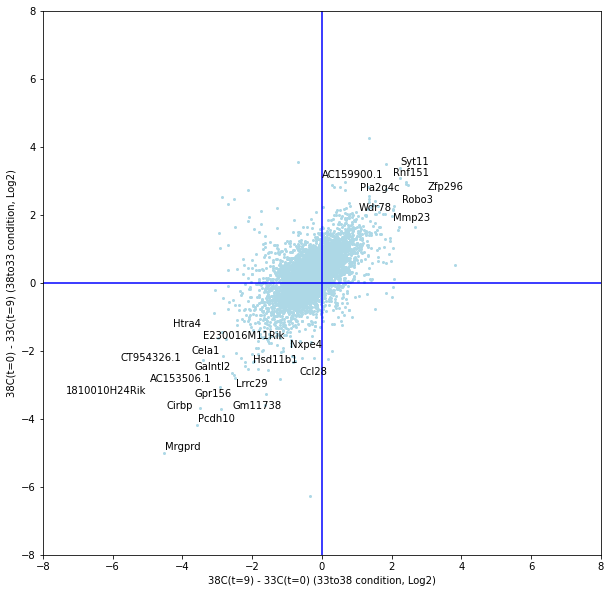

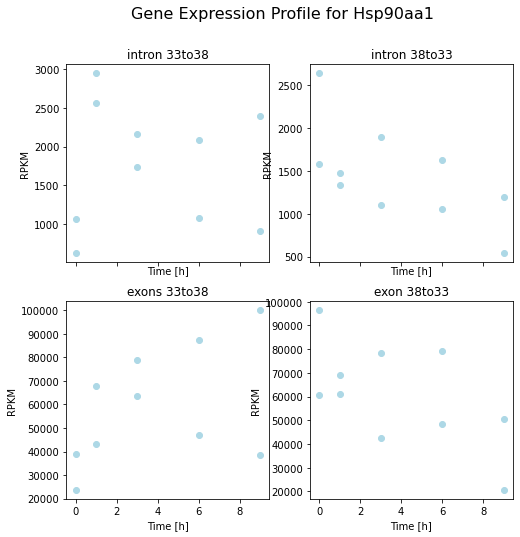

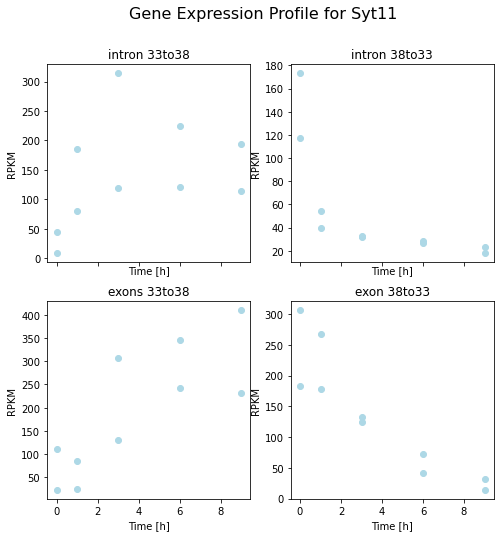

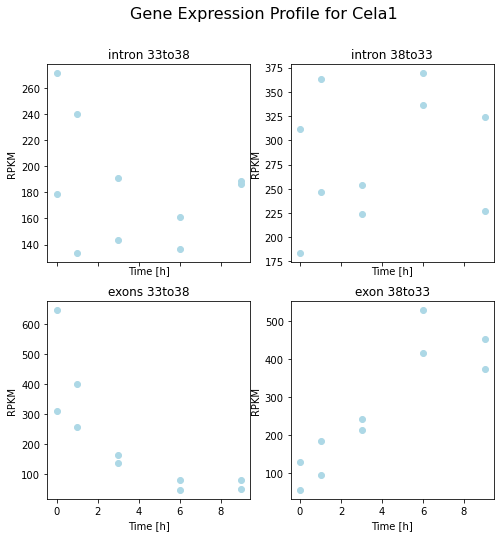

In [15]:
DE_genes = plot_DE(dat_all, condition_x1=['33to38'], condition_x2=['33to38'], condition_y1=['38to33'], condition_y2=['38to33'], # modify the condition parameters ['33to38'], ['38to33']
                time_x1=['0'], time_x2=['9'], time_y1=['9'], time_y2=['0'], # modify the time parameters ['0'], ['1'], ['3'], ['6'], ['9']
                feature_x1=['exon'], feature_x2=['exon'], feature_y1=['exon'], feature_y2=['exon'], # modify the feature parameters ['intron'], ['exon']
                FC=2, # adapt the FC threshold for readibility
                xlab='38C(t=9) - 33C(t=0) (33to38 condition, Log2)',
                ylab='38C(t=0) - 33C(t=9) (38to33 condition, Log2)',
                FC_type="delta") # this allows to select the type of fold change to use for the plot ("delta" or "delta_delta", extremities or out-of-diagonal)


plot_gene(dat_all,"Hsp90aa1")
plot_gene(dat_all,"Syt11") #heat-induced
plot_gene(dat_all,"Cela1") #cold-induced

**2.** One possibility is to compare the ratio (mRNA/pre-mRNA) at steady-state (t=0) between the two conditions. 
We can modify the *FC_type* parameter to highlight genes with different ratios between conditions (i.e. genes that are out of the diagonal). 

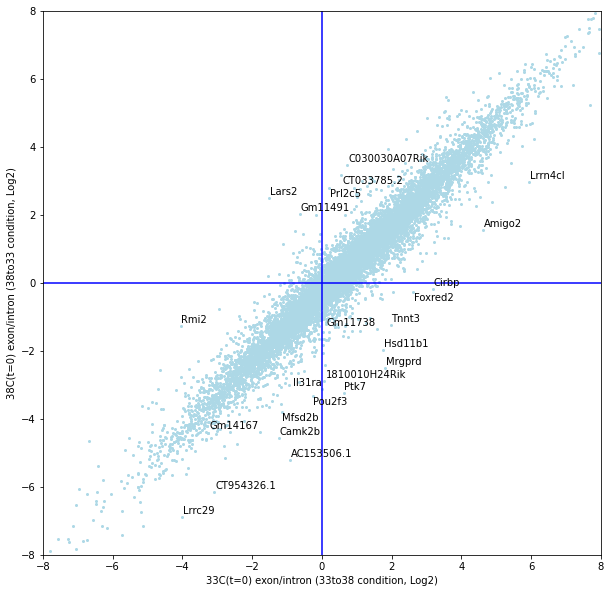

In [16]:
DE_genes = plot_DE(dat_all, condition_x1=['33to38'], condition_x2=['33to38'], condition_y1=['38to33'], condition_y2=['38to33'], # modify the condition parameters ['33to38'], ['38to33']
                time_x1=['0'], time_x2=['0'], time_y1=['0'], time_y2=['0'], # modify the time parameters ['0'], ['1'], ['3'], ['6'], ['9']
                feature_x1=['intron'], feature_x2=['exon'], feature_y1=['intron'], feature_y2=['exon'], # modify the feature parameters ['intron'], ['exon']
                FC=2.5, # adapt the FC threshold for readibility
                xlab='33C(t=0) exon/intron (33to38 condition, Log2)',
                ylab='38C(t=0) exon/intron (38to33 condition, Log2)',
                FC_type="delta_delta") # this allows to select the type of fold change to use for the plot ("delta" or "delta_delta", extremities or out-of-diagonal)


### Question 3

1. Using the *plot_gene* function, show the temporal dynamic of genes identified as having temperature-dependent regulation of gene expression in *Question 3*. 

2. What can you say in terms of transcriptional versus post-transcriptional regulation?  

3. Compare with the gene expression profile of *Cirbp*.

### Answer 3

1. Here are some examples of genes with temperature-dependent regulation identified in **Question 2**:  


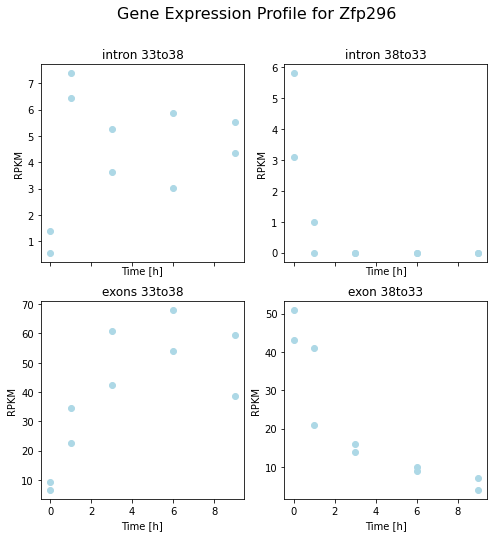

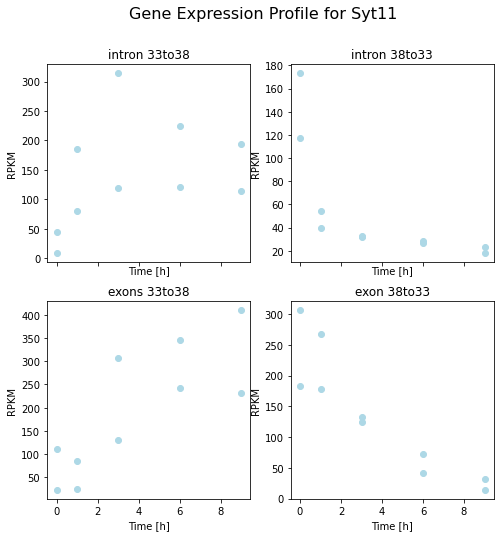

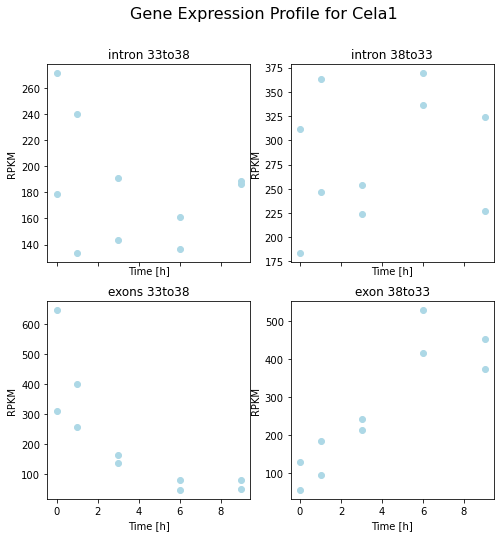

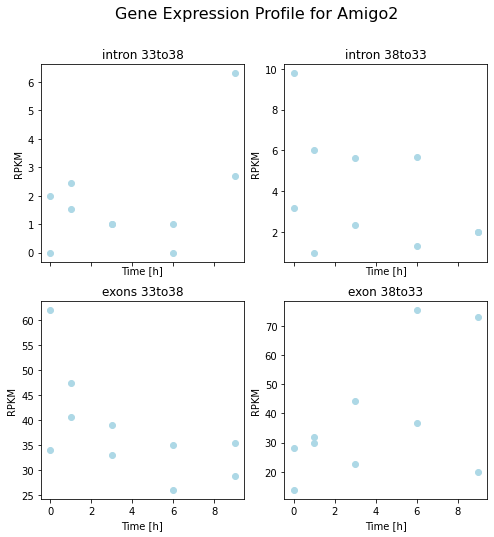

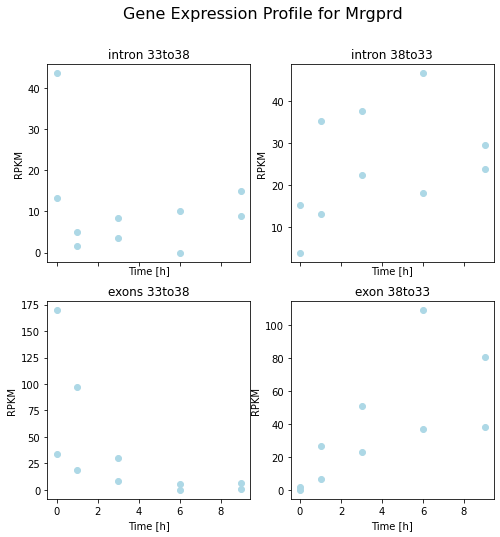

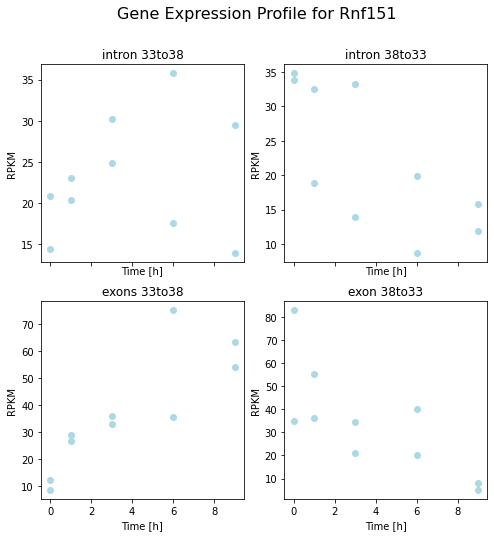

In [17]:
plot_gene(dat_all, 'Zfp296')
plot_gene(dat_all, 'Syt11')
plot_gene(dat_all, 'Cela1')
plot_gene(dat_all, 'Amigo2')
plot_gene(dat_all, 'Mrgprd')
plot_gene(dat_all, 'Rnf151')

**2.** Certain genes are regulated transcriptionally (*e.g. Syt11, Zfp286*) exhibiting increasing or decreasing intronic and exonic levels, whereas others are regulated post-transcriptionally, shown by constant intronic levels but variable exonic levels (*e.g. Cela1, Amigo2*).

**3.**

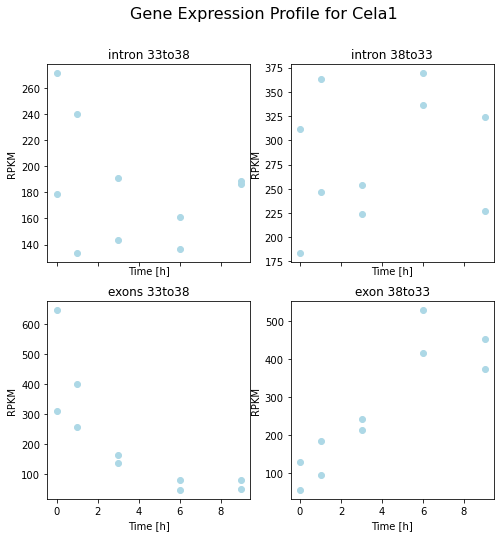

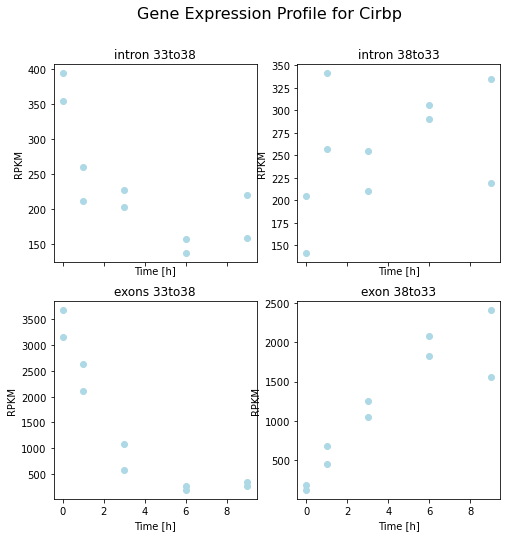

In [18]:
plot_gene(dat_all, 'Cela1')
plot_gene(dat_all, 'Cirbp')

### Question 4

We will now simulate the production decay model from Question 1 again, but with a temperature shift (i.e. temperature-dependent parameters).

1. Using the widget provided below, simulate the ODE with distinct parameters for the two temperatures. Comment on the outcome.

2. Use the widget to determine the parameters ($\rho_{33}$, $\rho_{38}$, $k_{m,33}$, $k_{m,38}$) that best fit *Cirbp* gene expression profile. Comment on your result.  

3. *Optional*: replace *Cirbp* with other genes identified previously as regulated post-transcriptionally. You might want to change the parameters and limits of the y-scale. Comment on your results. 


*Note: For simplification, compared to the model in the paper, we have used a model without the $\alpha$ parameter, which is still adequate for fitting most gene expression profiles. However, a limitation of this simplified model is that the obtained parameters may not be entirely realistic, which is the argument the authors used to favor the model with the $\alpha$ parameter.*

### Answer 4

**1/2.** Based on the publication and the described regulation of *Cirbp*, we set the parameters as follows: $k_{m,33}=0.151$, $k_{m,38}=0.466$, $rho_{33}=1.9$, $rho_{38}=0.34$. Upon the shift to cold-temperature, splicing rate is strongly increased and degradation rate is slightly decreased.



#### Implementation of the functions for the simulation with a temperature shift

In [19]:
def production_decay_ode_2(y, time, s, kp, km, rho):

    """
    Defines the ODEs for the production and decay of pre-mRNA and mRNA.
    P: pre-mRNA concentration
    M: mRNA concentration
    s: transcription rate (constant)
    kp: pre-mRNA degradation rate
    km: mRNA degradation rate
    rho: splicing rate

    """
    
    P, M = y
    dPdt = s - (kp + rho) * P
    dMdt = rho * P - km * M
    
    return [dPdt, dMdt] 


def compute_ss_param(s, kp, km, rho):
    """
    Compute the steady-state concentrations of pre-mRNA and mRNA (P_ss and M_ss) given the parameters of the model.

    """
    P_ss = s / (kp + rho)
    M_ss = (rho / km) * (s / kp + rho)
    return [P_ss, M_ss]  

def simulation_2(ode_function, parameters, initial_conditions = None, time = None):

    """
    Simulate the ODEs for the production and decay of pre-mRNA and mRNA.
    parameters: parameters for the ODEs
    initial_conditions: initial conditions for the ODEs
    time: time intervals for the simulation
    """

    s=parameters['s']
    kp=parameters['kp']
    km=parameters['km']
    rho=parameters['rho']

    xx=odeint(ode_function, initial_conditions, time, args=(s, kp, km, rho))
    
    return(xx)

def animate_2(time, s_33=5560, s_38=5560, km_33=0.151, km_38=0.466, kp= 20.794, rho_33=1.9, rho_38=0.34, gene='Cirbp'):
    
    """
    Runs the simulation with interactive widgets for parameter exploration and using the steady-state of each temperature condition as initial condition to simulate the switch.
    """

    #33 to 38
    initial_conditions = compute_ss_param(s_33, kp, km_33, rho_33)
    parameters = {'s':s_38,'km':km_38, 'kp':kp, 'rho':rho_38}
    xx_33_38 = simulation_2(production_decay_ode_2, parameters, initial_conditions, time)
    
    #38 to 33
    initial_conditions = compute_ss_param(s_38, kp, km_38, rho_38)

    parameters = {'s':s_33,'km':km_33, 'kp':kp, 'rho':rho_33}
    xx_38_33 = simulation_2(production_decay_ode_2, parameters, initial_conditions, time)
    
   
    plot_gene(dat_all, gene, xx_33_38, xx_38_33, time)    

#### Run the simulation

In [20]:
t = np.linspace(0,9,9*3600)
interact(animate_2, time=fixed(t), gene = 'Cirbp',
         s_33 = (500,10000,1), # [RPKM/hr] at 33C
         s_38 = (500,10000,1), # [RPKM/hr] at 38C
         km_33 = (0.05,2,0.05), # [hr^-1], you have to find the correct km_33 
         km_38 = (0.05,2,0.05), # [hr^-1], you have to find the correct km_38 
         kp = (0.05,24,0.1),  # [hr^-1], around 2min for Cirbp
         rho_33 = (0.05,5,0.1), # [hr^-1],  you have to find the correct rho_33 
         rho_38 = (0.05,5,0.1)); # [hr^-1], you have to find the correct rho_38

interactive(children=(IntSlider(value=5560, description='s_33', max=10000, min=500), IntSlider(value=5560, des…